In [1]:
import scipy as sp
from functools import partial
import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor


def MacroF1MetricRegression(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(np.int16)
    score = f1_score(labels, preds, average='macro')
    return ('MacroF1Metric', score, True)


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2  # just added
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(
                        np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(
                        np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(
                        np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(
                        np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(
                        np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    percent = 100 * (start_mem - end_mem) / start_mem
    print(
        'Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'
        .format(start_mem, end_mem, percent))
    return df


class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize F1 (Macro) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _f1_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients

        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf],
                     labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -f1_score(y, X_p, average='macro')

    def fit(self, X, y):
        """
        Optimize rounding thresholds

        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f1_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        print("Optimizing rounder...")
        self.coef_ = sp.optimize.minimize(loss_partial,
                                          initial_coef,
                                          method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds

        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        print("Rounding...")
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf],
                      labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']


def train_lgb(params: dict,
              X,
              y,
              X_test,
              oof_df,
              features,
              feval: dict = {},
              objective: str = 'regression',
              num_boost_round: int = 1,
              early_stopping_rounds: int = 50,
              verbose=10):
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    feat_importance_df = pd.DataFrame(index=features)
    fold = 0
    f1 = []
    for train_id, valid_id in tqdm(kfold.split(X, y)):
        fold += 1
        x_train, y_train = X.iloc[train_id, :], y.iloc[train_id]
        x_val, y_val = X.iloc[valid_id, :], y.iloc[valid_id]

        train_set = lgb.Dataset(x_train, y_train)
        valid_set = lgb.Dataset(x_val, y_val)

        model = lgb.train(params=params,
                          feval=feval[objective],
                          train_set=train_set,
                          num_boost_round=num_boost_round,
                          early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_set, valid_set],
                          verbose_eval=verbose)
        pred = model.predict(x_val, num_iteration=model.best_iteration)

        pred = np.round(np.clip(pred, 0, 10)).astype(np.int32)

        test_preds = model.predict(X_test, num_iteration=model.best_iteration)

        test_preds = np.round(np.clip(test_preds, 0, 10)).astype(np.int32)

        oof_df.loc[oof_df.iloc[valid_id].index, 'oof'] = pred
        sub[f'lgb_open_channels_fold_{fold}'] = test_preds

        f1.append(
            f1_score(oof_df.loc[oof_df.iloc[valid_id].index]['open_channels'],
                     oof_df.loc[oof_df.iloc[valid_id].index]['oof'],
                     average='macro'))
        rmse = np.sqrt(
            mean_squared_error(
                oof_df.loc[oof_df.index.isin(valid_id)]['open_channels'],
                oof_df.loc[oof_df.index.isin(valid_id)]['oof']))
        feat_importance_df[
            f'lgb_importance_{fold}'] = model.feature_importance()

    print(f"Mean oof f1:{np.mean(f1)}, std: {np.std(f1)}")

    oof_f1 = f1_score(oof_df['open_channels'], oof_df['oof'], average='macro')
    oof_rmse = np.sqrt(
        mean_squared_error(oof_df['open_channels'], oof_df['oof']))

    return oof_df.copy(), feat_importance_df.copy(), sub.copy(
    ), oof_f1, oof_rmse


def train_xgb(params: dict,
              X,
              y,
              X_test,
              oof_df,
              features,
              feval: dict = {},
              verbose_eval=100,
              objective: str = 'regression',
              num_boost_round: int = 1,
              early_stopping_rounds: int = 50,
              sklearn_model=None):
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    feat_importance_df = pd.DataFrame(index=features)
    fold = 0
    f1 = []
    for train_id, valid_id in kfold.split(X, y):
        fold += 1
        x_train, y_train = X.iloc[train_id, :], y.iloc[train_id]
        x_val, y_val = X.iloc[valid_id, :], y.iloc[valid_id]

        train_set = xgb.DMatrix(x_train, y_train)
        valid_set = xgb.DMatrix(x_val, y_val)

        model = xgb.train(params,
                          train_set,
                          num_boost_round=num_boost_round,
                          evals=[(train_set, 'train'), (valid_set, 'val')],
                          feval=feval[objective],
                          verbose_eval=verbose_eval,
                          maximize=True,
                          early_stopping_rounds=early_stopping_rounds)
        pred = model.predict(xgb.DMatrix(x_val))
        pred = np.round(np.clip(pred, 0, 10)).astype(np.int32)

        test_preds = model.predict(xgb.DMatrix(X_test))
        test_preds = np.round(np.clip(test_preds, 0, 10)).astype(np.int32)

        oof_df.loc[oof_df.iloc[valid_id].index, 'oof'] = pred
        sub[f'{model_type}_open_channels_fold_{fold}'] = test_preds

        f1 = f1_score(oof_df.loc[oof_df.iloc[valid_id].index]['open_channels'],
                      oof_df.loc[oof_df.iloc[valid_id].index]['oof'],
                      average='macro')
        f1.append(
            f1_score(oof_df.loc[oof_df.iloc[valid_id].index]['open_channels'],
                     oof_df.loc[oof_df.iloc[valid_id].index]['oof'],
                     average='macro'))
        rmse = np.sqrt(
            mean_squared_error(
                oof_df.loc[oof_df.index.isin(valid_id)]['open_channels'],
                oof_df.loc[oof_df.index.isin(valid_id)]['oof']))

    oof_f1 = f1_score(oof_df['open_channels'], oof_df['oof'], average='macro')
    oof_rmse = np.sqrt(
        mean_squared_error(oof_df['open_channels'], oof_df['oof']))
    
    print(f"Mean oof f1:{np.mean(f1)}, std: {np.std(f1)}")
    return oof_df.copy(), feat_importance_df.copy(), sub.copy(
    ), oof_f1, oof_rmse


feval = {
    # 'classification': MacroF1MetricClassification,
    'regression': MacroF1MetricRegression
}

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
train = pd.read_csv('liverpool-ion-switching/train.csv',
                    dtype={
                        'time': np.float32,
                        'signal': np.float32,
                        'open_channels': np.int32
                    })
test = pd.read_csv('liverpool-ion-switching/test.csv',
                    dtype={
                        'time': np.float32,
                        'signal': np.float32,
                    })
sub = pd.read_csv('liverpool-ion-switching/sample_submission.csv')

## Features

In [3]:
def feature_eng(df: pd.DataFrame, bs=500_000, bs_slice=25_000, windows=(10, 50)):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // bs
    df['batch_index'] = df.index - (df.batch * bs)
    df['batch_slices'] = df['batch_index'] // bs_slice
    df['batch_slices2'] = df['batch'].astype(str).str.zfill(
        3) + '_' + df['batch_slices'].astype(str).str.zfill(3)

    for c in tqdm(['batch', 'batch_slices2']):
        df[f'batch_{bs//1000}k_max_{c}'] = df.groupby(
            [f'{c}'])['signal_undrifted'].transform(np.max)
        df[f'batch_{bs//1000}k_min_{c}'] = df.groupby(
            [f'{c}'])['signal_undrifted'].transform(np.min)
        df[f'batch_{bs//1000}k_mean_{c}'] = df.groupby(
            [f'{c}'])['signal_undrifted'].transform(np.mean)
        df[f'batch_{bs//1000}k_std_{c}'] = df.groupby(
            [f'{c}'])['signal_undrifted'].transform(np.std)
        df[f'batch_{bs//1000}k_median_{c}'] = df.groupby(
            [f'{c}'])['signal_undrifted'].transform(np.median)
        df[f'batch_{bs//1000}k_diff_max_{c}'] = df.groupby([
            f'{c}'
        ])['signal_undrifted'].transform(lambda x: np.max(np.diff(x)))

        df[f'batch_{bs//1000}k_diff_min_{c}'] = df.groupby([
            f'{c}'
        ])['signal_undrifted'].transform(lambda x: np.min(np.diff(x)))
        df[f'batch_{bs//1000}k_range_{c}'] = np.abs(
            df[f'batch_{bs//1000}k_max_{c}'] -
            df[f'batch_{bs//1000}k_min_{c}'])
        df[f'batch_{bs//1000}k_maxtomin_{c}'] = np.abs(
            (df[f'batch_{bs//1000}k_max_{c}'] + 1e-10) /
            (df[f'batch_{bs//1000}k_min_{c}'] + 1e-10))

        df[f'batch_{bs//1000}k_shift_1_{c}'] = df.groupby(
            [f'{c}']).shift(1)['signal_undrifted']
        df[f'batch_{bs//1000}k_shift_-1_{c}'] = df.groupby(
            [f'{c}']).shift(-1)['signal_undrifted']
        df[f'batch_{bs//1000}k_shift_2_{c}'] = df.groupby(
            [f'{c}']).shift(2)['signal_undrifted']
        df[f'batch_{bs//1000}k_shift_-2_{c}'] = df.groupby(
            [f'{c}']).shift(-2)['signal_undrifted']
        for window in tqdm(windows):
            df[f'batch_{bs//1000}k_rolling_max_{c}_{window}'] = df[
                'signal_undrifted'].rolling(window=window).max()
            df[f'batch_{bs//1000}k_rolling_min_{c}_{window}'] = df[
                'signal_undrifted'].rolling(window=window).min()
            df[f'batch_{bs//1000}k_rolling_maxtomin_{c}_{window}'] = (
                df[f'batch_{bs//1000}k_rolling_max_{c}_{window}'] + 1e-10) / (
                    df[f'batch_{bs//1000}k_rolling_min_{c}_{window}'] + 1e-10)
            df[f'batch_{bs//1000}k_rolling_range_{c}_{window}'] = df[
                f'batch_{bs//1000}k_rolling_max_{c}_{window}'] - df[
                    f'batch_{bs//1000}k_rolling_min_{c}_{window}']

            df[f'batch_{bs//1000}k_rolling_mean_{c}_{window}'] = df[
                'signal_undrifted'].rolling(window=window).mean()
            df[f'batch_{bs//1000}k_rolling_std_{c}_{window}'] = df[
                'signal_undrifted'].rolling(window=window).std()

    feats = [
        c for c in df.columns if c not in [
            'time', 'open_channels', 'batch', 'batch_index', 'batch_slices',
            'batch_slices2'
        ]
    ]
    for c in feats:
        df[c + '_msignal'] = df[c] - df['signal_undrifted']
    feats = [
        c for c in df.columns if c not in [
            'time', 'open_channels', 'batch', 'batch_index', 'batch_slices',
            'batch_slices2'
        ]
    ]
    
    return df, feats

In [4]:
a = 500000
b = 600000
train['signal_undrifted'] = train.signal
train.loc[train.index[a:b],
          'signal_undrifted'] = train.signal[a:b].values - 3 * (
              train.time.values[a:b] - 50) / 10.


def f(x, low, high, mid):
    return -((-low + high) / 625) * (x - mid)**2 + high - low


# CLEAN TRAIN BATCH 7
batch = 7
a = 500000 * (batch - 1)
b = 500000 * batch
train.loc[train.index[a:b], 'signal_undrifted'] = train.signal.values[a:b] - f(
    train.time[a:b].values, -1.817, 3.186, 325)
# CLEAN TRAIN BATCH 8
batch = 8
a = 500000 * (batch - 1)
b = 500000 * batch
train.loc[train.index[a:b], 'signal_undrifted'] = train.signal.values[a:b] - f(
    train.time[a:b].values, -0.094, 4.936, 375)
# CLEAN TRAIN BATCH 9
batch = 9
a = 500000 * (batch - 1)
b = 500000 * batch
train.loc[train.index[a:b], 'signal_undrifted'] = train.signal.values[a:b] - f(
    train.time[a:b].values, 1.715, 6.689, 425)
# CLEAN TRAIN BATCH 10
batch = 10
a = 500000 * (batch - 1)
b = 500000 * batch
train.loc[train.index[a:b], 'signal_undrifted'] = train.signal.values[a:b] - f(
    train.time[a:b].values, 3.361, 8.45, 475)

test['signal_undrifted'] = test.signal

# REMOVE BATCH 1 DRIFT
start=500
a = 0; b = 100000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=510
a = 100000; b = 200000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=540
a = 400000; b = 500000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.

# REMOVE BATCH 2 DRIFT
start=560
a = 600000; b = 700000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=570
a = 700000; b = 800000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=580
a = 800000; b = 900000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.

# REMOVE BATCH 3 DRIFT
def f(x):
    return -(0.00788)*(x-625)**2+2.345 +2.58
a = 1000000; b = 1500000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - f(test.time[a:b].values)

In [5]:
train, features = feature_eng(train, bs=25_000, bs_slice=2500, windows=[10,50])
train = reduce_mem_usage(train)
test, _ = feature_eng(test, bs=25_000, bs_slice=2500, windows=[10,50])
test = reduce_mem_usage(test)


Mem. usage decreased from 3478.29 Mb to 1461.27 Mb (58.0% reduction)



Mem. usage decreased from 1384.74 Mb to 568.39 Mb (59.0% reduction)


In [6]:
len(features)

104

## Signal Analysis

In [45]:
from scipy import signal as sps
from numpy import fft
import pywt

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

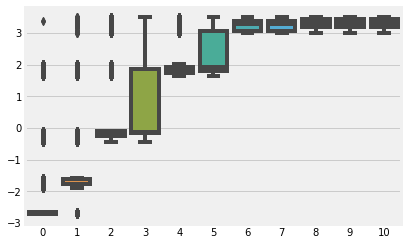

In [116]:
sns.boxplot(x=train['open_channels'].values, y=train['batch_50k_median_batch'].values)

## `LightGBM`

In [223]:
params_lgb = {
    'learning_rate': 0.015,  #0.098
    'max_depth': 7,
    'num_leaves': 200,  #2**8 + 1,
    'metric': 'rmse',
    'random_state': 42,
    'n_jobs': -1,
    'sample_fraction': 0.33
}

X = train[features]
X_test = test[features]
y = train['open_channels']
oof_df = train[['time', 'open_channels']].copy()

In [224]:
oof_df_lgb, feat_importance_df_lgb, sub_lgb2, oof_f2, oof_rmse2 = train_lgb(
    params=params_lgb,
    X=X,
    y=y,
    X_test=X_test,
    early_stopping_rounds=150,
    num_boost_round=2000,  # 3000
    oof_df=oof_df,
    features=features,
    feval=feval,
    verbose=100)

Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.610725	training's MacroF1Metric: 0.339966	valid_1's rmse: 0.610983	valid_1's MacroF1Metric: 0.340484
[200]	training's rmse: 0.207942	training's MacroF1Metric: 0.920234	valid_1's rmse: 0.208619	valid_1's MacroF1Metric: 0.919486
[300]	training's rmse: 0.162333	training's MacroF1Metric: 0.934983	valid_1's rmse: 0.163312	valid_1's MacroF1Metric: 0.93458
[400]	training's rmse: 0.158425	training's MacroF1Metric: 0.936598	valid_1's rmse: 0.159669	valid_1's MacroF1Metric: 0.936183
[500]	training's rmse: 0.157381	training's MacroF1Metric: 0.937226	valid_1's rmse: 0.158853	valid_1's MacroF1Metric: 0.936848
[600]	training's rmse: 0.156822	training's MacroF1Metric: 0.937691	valid_1's rmse: 0.158488	valid_1's MacroF1Metric: 0.937016
[700]	training's rmse: 0.156379	training's MacroF1Metric: 0.937904	valid_1's rmse: 0.158267	valid_1's MacroF1Metric: 0.937025
[800]	training's rmse: 0.156015	training's MacroF1Metric:

[700]	training's rmse: 0.156289	training's MacroF1Metric: 0.937886	valid_1's rmse: 0.158369	valid_1's MacroF1Metric: 0.936758
[800]	training's rmse: 0.155928	training's MacroF1Metric: 0.938088	valid_1's rmse: 0.158207	valid_1's MacroF1Metric: 0.936957
[900]	training's rmse: 0.155639	training's MacroF1Metric: 0.938214	valid_1's rmse: 0.158104	valid_1's MacroF1Metric: 0.937012
[1000]	training's rmse: 0.155351	training's MacroF1Metric: 0.938389	valid_1's rmse: 0.158001	valid_1's MacroF1Metric: 0.937035
[1100]	training's rmse: 0.155073	training's MacroF1Metric: 0.938559	valid_1's rmse: 0.157904	valid_1's MacroF1Metric: 0.937086
[1200]	training's rmse: 0.154794	training's MacroF1Metric: 0.93872	valid_1's rmse: 0.157801	valid_1's MacroF1Metric: 0.937091
[1300]	training's rmse: 0.15453	training's MacroF1Metric: 0.938891	valid_1's rmse: 0.157702	valid_1's MacroF1Metric: 0.937164
[1400]	training's rmse: 0.154276	training's MacroF1Metric: 0.939027	valid_1's rmse: 0.157622	valid_1's MacroF1Metric

In [8]:
sub_lgb2['open_channels'] = sub_lgb2.iloc[:, 2:].median(axis=1).astype(int)

sub_lgb2[['time', 'open_channels']].to_csv('submission_lgb_with_drift_rolling.csv', 
                                           index=False,
                                           float_format='%.4f')

In [229]:
!kaggle competitions submit -c liverpool-ion-switching -f submission_lgb_with_drift_rolling.csv -m "with drift removed"

100%|██████████████████████████████████████| 21.0M/21.0M [00:10<00:00, 2.19MB/s]
Successfully submitted to University of Liverpool - Ion Switching

In [230]:
oof_df_lgb.to_csv('oof_df_lgb_undrifted_rolling.csv', index=False)
feat_importance_df_lgb.to_csv('feat_importance_df_lgb_undrifted_rolling.csv', index=False)
sub_lgb2.to_csv('sub_lgb_with_folds_undrifted_rolling.csv', index=False, float_format='%.4f')


### Prediction of LGBM

In [9]:
sub_lgb2 = pd.read_csv('sub_lgb_with_folds_undrifted_rolling.csv')
sub_lgb2['open_channels'] = np.round(np.clip(sub_lgb2.iloc[:, 2:].mean(axis=1).values, 0, 10)).astype(np.int32)

sub_lgb2[['time', 'open_channels']].to_csv('submission_lgb_with_drift_rolling_mean.csv', 
                                           index=False,
                                           float_format='%.4f')

In [10]:
!kaggle competitions submit -c liverpool-ion-switching -f submission_lgb_with_drift_rolling_mean.csv -m "with drift removed and mean"



100%|██████████████████████████████████████| 21.0M/21.0M [00:08<00:00, 2.50MB/s]
Successfully submitted to University of Liverpool - Ion Switching

## `XGBoost`

In [13]:
params_xgb = {
    'colsample_bytree': 0.375,
    'learning_rate': 0.09,
    'max_depth': 8,
    'seed': 42,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'reg_lambda': 1, # these are default
    'reg_alpha': 0 # these are default
}
def MacroF1MetricRegressionXGB(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(np.int16)
    score = f1_score(labels, preds, average='macro')
    return ('MacroF1MetricXGB', score)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
X = train[features]
X_test = test[features]
y = train['open_channels']
oof_df = train[['time', 'open_channels']].copy()

In [ ]:
oof_df_xgb, feat_importance_df_xgb, sub_xgb, oof_f1, oof_rmse = train_xgb(
    X=X,
    y=y,
    X_test=X_test,
    verbose_eval=100,
    oof_df=oof_df,
    features=features,
    params=params_xgb,
    feval={'regression':MacroF1MetricRegressionXGB},
    objective='regression',
    num_boost_round=3000,
    early_stopping_rounds=150
)

## `PyTorch` ?

## Combine and Submit

In [ ]:
s_cols = [s for s in sub.columns if 'open_channels' in s]

sub['open_channels'] = sub[s_cols].median(axis=1).astype(int)

sub.head()